In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
from patchify import patchify, unpatchify

In [3]:
from pathlib import Path
import tensorflow as tf

2022-09-28 07:48:02.375111: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
data_folder = '../datasets/infer'
image_filenames = os.listdir(f'{data_folder}/images')
image_filenames[0]

'1113.png'

In [21]:
import albumentations as A
import cv2
from PIL import Image
import numpy as np

import segmentation_models as sm

def load_model(backbone: str, checkpoint: str, n_classes: int = 2, activation: str = 'softmax'):
    model = sm.Unet(backbone, encoder_weights='imagenet', classes=n_classes, activation=activation)
    model.load_weights(checkpoint)
    return model

def load_fpn_model(backbone: str, checkpoint: str, n_classes: int = 2, activation: str = 'softmax'):
    model = sm.FPN(backbone, encoder_weights='imagenet', classes=n_classes, activation=activation)
    model.load_weights(checkpoint)
    return model

def overlay(image, mask):
    return Image.composite(image, Image.new('RGB', image.size, (255,0,0)), mask.convert('L'))


# original_size = (1632, 1248)
orig_size = (1232, 1624)
# pad_size = (1280, 1920)
pad_size = (1280, 1792)
transform = A.Compose([A.CLAHE(always_apply=True), A.PadIfNeeded(*pad_size, always_apply=True)])
# transform = A.Compose([A.PadIfNeeded(*pad_size, always_apply=True)])
inverse_transform = A.Compose([A.CenterCrop(*orig_size),])
images = [cv2.imread(f"{data_folder}/images/{image_filenames[i]}",cv2.IMREAD_COLOR) for i in range(len(image_filenames))]
images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]


apply_transform = lambda transform, image: transform(image=image)['image']
apply_transform_mask = lambda transform, image: transform(mask=mask)['mask']

transformed_images = [apply_transform(transform, image) for image in images]

In [222]:
# cp = 'fpn_checkpoint_fixed_whole/resnet34_backbone_50epochs_bs4_lr0.005_size320.hdf5'
# cp = 'fpn_checkpoint_predicted_whole_5like/resnet34_backbone_50epochs_bs4_lr0.001_size256.hdf5'
# cp = 'fpn_checkpoint_handpicked/resnet34_backbone_50epochs_bs4_lr0.001_size320.hdf5'

# cp = 'unet_checkpoint_handpicked/resnet34_backbone_100epochs_bs4_lr0.001_size640.hdf5'
# cp = 'unet_checkpoint_mini/resnet34_backbone_100epochs_bs1_lr0.001_size1024.hdf5'
# cp = 'unet_checkpoint_mini_daria_2/resnet34_backbone_100epochs_bs1_lr0.002_size1632.hdf5'

# cp = 'unet_checkpoint_best/resnet34_backbone_200epochs_bs4_lr0.002_size800.hdf5'
cp = 'unet_checkpoint_plane/resnet34_backbone_200epochs_bs4_lr0.002_size800.hdf5'
cp = 'unet_checkpoint_plane/resnet34_backbone_200epochs_bs4_lr0.002_size1024.hdf5'
cp = 'unet_checkpoint_plane_continue/resnet34_backbone_200epochs_bs4_lr0.002_size800.hdf5'

cp = 'unet_checkpoint_last_continue/resnet34_backbone_200epochs_bs4_lr0.002_size800.hdf5'
cp = 'unet_checkpoint_last/resnet34_backbone_200epochs_bs4_lr0.002_size1024.hdf5'

# cp = 'checkpoint_predicted_whole_5like/resnet34_backbone_50epochs_bs4_lr0.001_size256.hdf5'
# cp = 'checkpoint_fixed_mini_5like/resnet34_backbone_50epochs_bs4_lr0.0001_size256.hdf5'
# cp = 'checkpoint_predicted_whole_mini/resnet50_backbone_50epochs_bs8_lr0.001_size256.hdf5'

# cp = 'checkpoint_predicted_whole_mini_new/resnet50_backbone_50epochs_bs4_lr0.001_size256.hdf5'
# cp = 'checkpoint_predicted_whole_mini_new_continue/resnet50_backbone_50epochs_bs8_lr1e-05_size256.hdf5'
# cp = 'checkpoint_predicted_whole_mini/'
bbone = 'resnet34'
model = load_model(bbone, cp)
# model = load_fpn_model(bbone, cp)

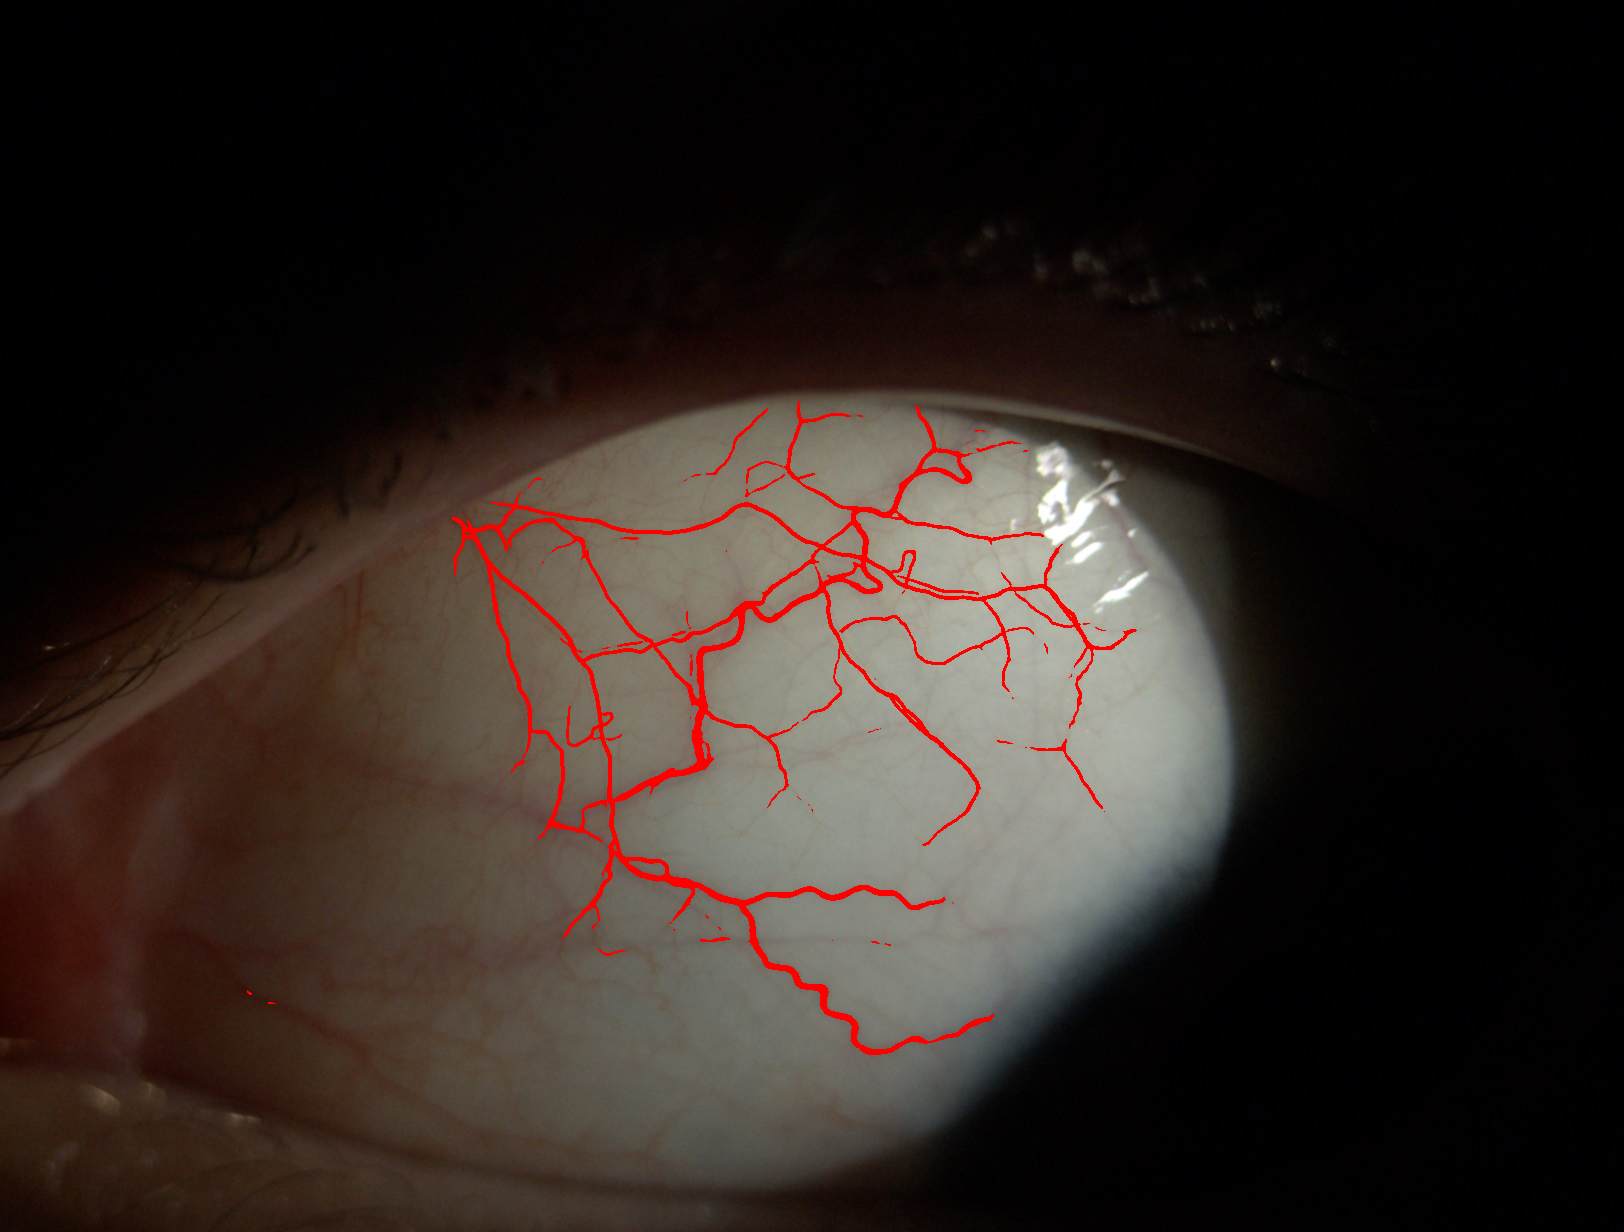

In [228]:
index = np.random.randint(len(transformed_images))

patches_tensor = tf.expand_dims(tf.convert_to_tensor(transformed_images[index]), axis=0)
mask_pred = tf.argmax(model(patches_tensor),axis=-1).numpy().astype(np.uint8)[0,:,:]*255
mask_pred = inverse_transform(image=mask_pred)['image']
overlay(Image.fromarray(images[index]), Image.fromarray(255-mask_pred))

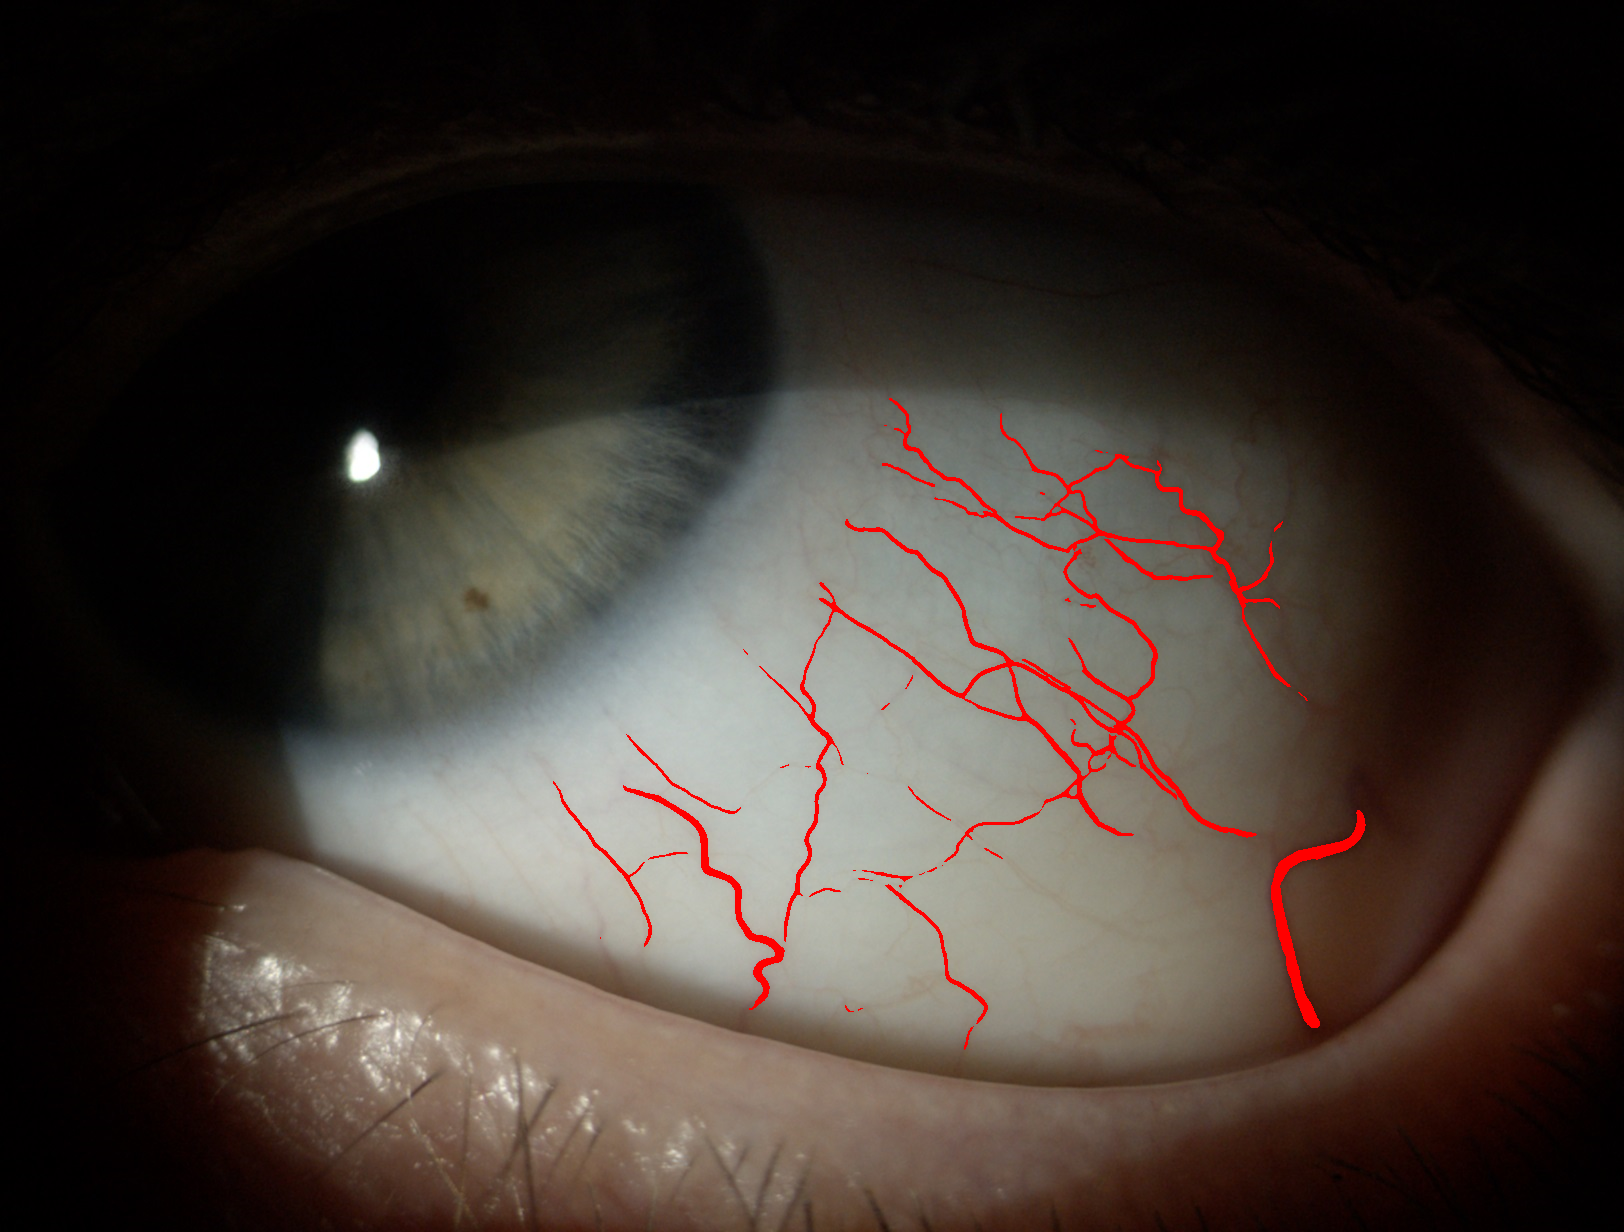

In [113]:
orig_mask = Image.open(f'submit-best-temp-3/{Path(image_filenames[index]).name}')
mask = Image.fromarray(255-np.asarray(orig_mask))
overlay(Image.fromarray(images[index]), mask)

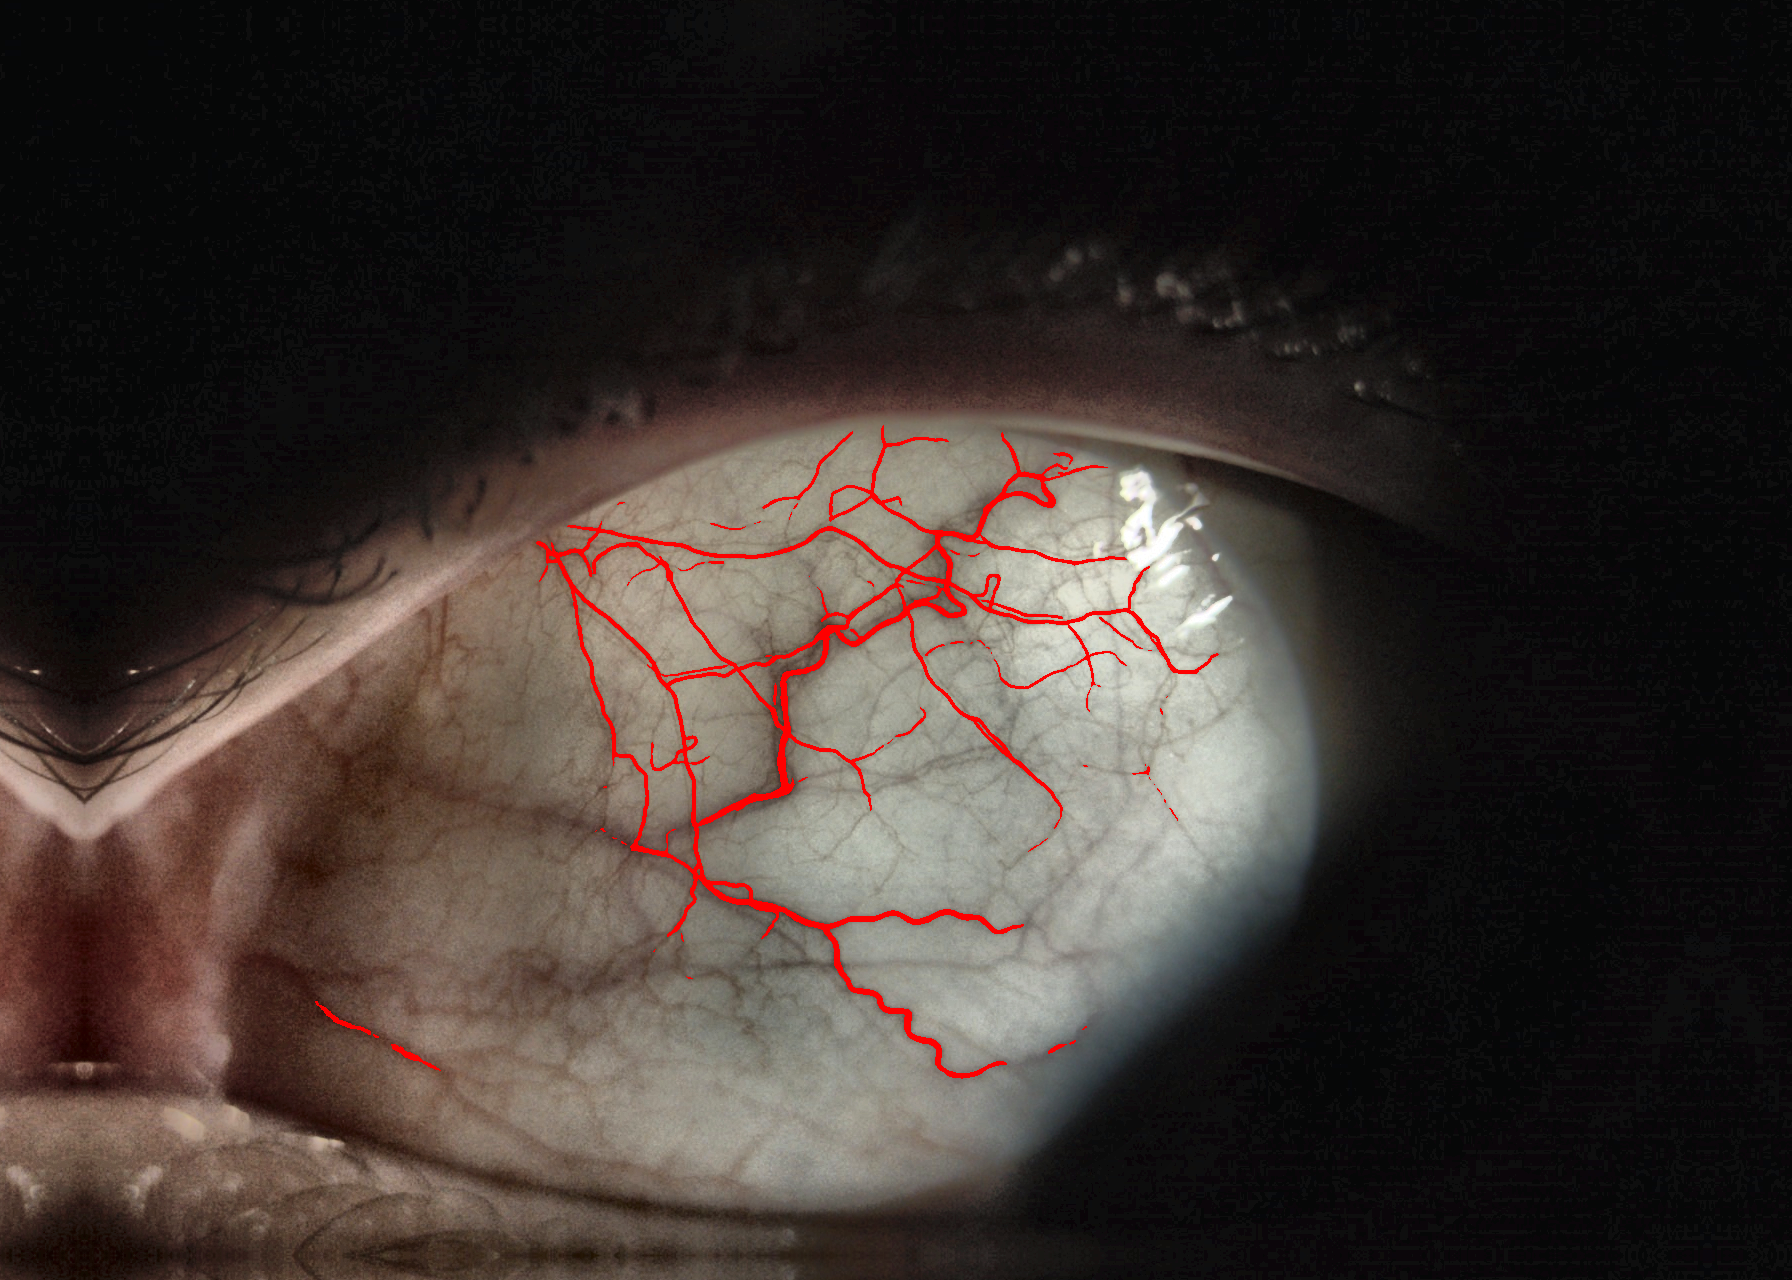

In [229]:
orig_mask = Image.open(f'submit-best-temp-16-800/{Path(image_filenames[index]).name}')
mask = Image.fromarray(apply_transform(transform, 255-np.asarray(orig_mask)))
overlay(Image.fromarray(transformed_images[index]), mask)

In [ ]:
patch_size = 640
patches = patchify(transformed_images[index], (patch_size, patch_size,3), patch_size,)
patches_tensor = tf.convert_to_tensor(patches.reshape(patches.shape[0]*patches.shape[1],patch_size,patch_size,3))
preds = tf.argmax(model(patches_tensor),axis=-1).numpy().astype(np.uint8)*255
preds_mask = np.expand_dims(preds.reshape(patches.shape[:-1]), axis=-1)
mask_pred = unpatchify(preds_mask, list(pad_size) + [1,])

overlay(Image.fromarray(transformed_images[index]), Image.fromarray(255-mask_pred[:,:,0]))

In [220]:
# index = np.random.randint(len(transformed_images))
folder = 'submit-best-temp-16-800'
os.makedirs(folder, exist_ok=True)
for index in range(len(transformed_images)):
    # patches = patchify(transformed_images[index], (256, 256,3), 256,)
    patches_tensor = tf.expand_dims(tf.convert_to_tensor(transformed_images[index]), axis=0)
    mask_pred = tf.argmax(model(patches_tensor),axis=-1).numpy().astype(np.uint8)[0,:,:]*255
    mask_pred = inverse_transform(image=mask_pred)['image']
    # preds_mask = np.expand_dims(preds.reshape(patches.shape[:-1]), axis=-1)
    # mask_pred = unpatchify(preds, list(pad_size) + [1,])
    Image.fromarray(mask_pred).save(f"{folder}/{image_filenames[index]}")
#     break

In [221]:
# index = np.random.randint(len(transformed_images))
folder = 'submit-best-temp-16-f-800'
os.makedirs(folder, exist_ok=True)
for index in range(len(transformed_images)):
    # patches = patchify(transformed_images[index], (256, 256,3), 256,)
    patches_tensor = tf.expand_dims(tf.convert_to_tensor(transformed_images[index]), axis=0)
    pred1 = model(patches_tensor)
    pred2 = tf.image.flip_left_right(model(tf.image.flip_left_right(patches_tensor)))
    mask_pred = tf.argmax(pred1*.5 + pred2*.5,axis=-1).numpy().astype(np.uint8)[0,:,:]*255
    mask_pred = inverse_transform(image=mask_pred)['image']
    # preds_mask = np.expand_dims(preds.reshape(patches.shape[:-1]), axis=-1)
    # mask_pred = unpatchify(preds, list(pad_size) + [1,])
    Image.fromarray(mask_pred).save(f"{folder}/{image_filenames[index]}")
#     break